In [1]:
%reset -f
import torch
torch.cuda.empty_cache()


In [2]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

In [ ]:
from torchinfo import summary
from model import Resnet_UNet
summary(Resnet_UNet(), input_size=(1, 3, 1000, 750), 
        row_settings=["var_names"],
        col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
        col_width=16)

/home/kagami/miniconda3/envs/tsmc/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kagami/miniconda3/envs/tsmc/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer (type (var_name))                  Kernel Shape     Output Shape     Param #          Mult-Adds
Resnet_UNet (Resnet_UNet)                --               [1, 1, 1000, 750] 513,000          --
├─Conv2d (conv1)                         [7, 7]           [1, 64, 500, 375] 9,408            1,764,000,000
├─BatchNorm2d (bn1)                      --               [1, 64, 500, 375] 128              128
├─ReLU (relu)                            --               [1, 64, 500, 375] --               --
├─MaxPool2d (maxpool)                    3                [1, 64, 250, 188] --               --
├─Sequential (block1)                    --               [1, 64, 250, 188] --               --
│    └─BasicBlock (0)                    --               [1, 64, 250, 188] --               --
│    │    └─Conv2d (conv1)               [3, 3]           [1, 64, 250, 188] 36,864           1,732,608,000
│    │    └─BatchNorm2d (bn1)            --               [1, 64, 250, 188] 128              128
│    │    

## Utils

In [6]:
import matplotlib
import matplotlib.cm
import numpy as np

def DepthNorm(depth, maxDepth=111.0): 
    return depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin=10, vmax=1000, cmap='plasma'):
    value = value.cpu().numpy()[0,:,:]

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    #value = value.squeeze(axis=0)

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=True) # (nxmx4)

    img = value[:,:,:3]

    return img.transpose((2,0,1))

## Load Data

In [ ]:
# %%
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from io import BytesIO
import random
import torchvision.transforms.functional as F
import torchvision.transforms.functional as TF

class ApplyTransformToBoth:
    def __init__(self, image_transform, depth_transform=None):
        self.image_transform = image_transform
        self.depth_transform = depth_transform

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        if self.image_transform:
            image = self.image_transform(image)
        if self.depth_transform:
            depth = self.depth_transform(depth)
        return {'image': image, 'depth': depth}

def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

class RandomHorizontalFlip(object):
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']

        if not _is_pil_image(image):
            raise TypeError('img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth):
            raise TypeError('img should be PIL Image. Got {}'.format(type(depth)))

        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            depth = depth.transpose(Image.FLIP_LEFT_RIGHT)

        return {'image': image, 'depth': depth}

class RandomResizedCrop(object):
    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)):
        self.size = size
        self.scale = scale
        self.ratio = ratio

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']

        if not _is_pil_image(image):
            raise TypeError('img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth):
            raise TypeError('img should be PIL Image. Got {}'.format(type(depth)))

        # Get random crop parameters
        i, j, h, w = transforms.RandomResizedCrop.get_params(image, self.scale, self.ratio)
        
        # Crop the image and depth map using the same parameters
        image = TF.resized_crop(image, i, j, h, w, self.size)
        depth = TF.resized_crop(depth, i, j, h, w, self.size)

        return {'image': image, 'depth': depth}

class RandomChannelSwap(object):
    def __init__(self, probability):
        from itertools import permutations
        self.probability = probability
        self.indices = list(permutations(range(3), 3))

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        if not _is_pil_image(image): 
            raise TypeError('img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth): 
            raise TypeError('img should be PIL Image. Got {}'.format(type(depth)))
        if random.random() < self.probability:
            image = np.asarray(image)
            image = Image.fromarray(image[..., list(self.indices[random.randint(0, len(self.indices) - 1)])])
        return {'image': image, 'depth': depth}

def loadZipToMem(zip_file):
    # Load zip file into memory
    print('Loading dataset zip file...', end='')
    from zipfile import ZipFile
    input_zip = ZipFile(zip_file)
    data = {name: input_zip.read(name) for name in input_zip.namelist()}
    
    print('Files in the ZIP archive:')
    for file_name in data.keys():
        print(file_name)
    nyu2_train = list((row.split(',') for row in (data['sem_images/output.csv']).decode("utf-8").split('\n') if len(row) > 0))
    nyu2_train = [tuple(item.strip() for item in row) for row in nyu2_train]

    from sklearn.utils import shuffle
    nyu2_train = shuffle(nyu2_train, random_state=0)

    # if True: nyu2_train = nyu2_train[:40]

    print('Loaded ({0}).'.format(len(nyu2_train)))
    return data, nyu2_train

class depthDatasetMemory(Dataset):
    def __init__(self, data, nyu2_train, transform=None):
        self.data, self.nyu_dataset = data, nyu2_train
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.nyu_dataset[idx]
        image = Image.open(BytesIO(self.data[sample[0]]))
        depth = Image.open(BytesIO(self.data[sample[1]]))
        
        # Convert the image to RGB format
        image = image.convert('RGB')
        # Keep the depth map in grayscale format
        depth = depth.convert('L')

        sample = {'image': image, 'depth': depth}
        if self.transform: 
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.nyu_dataset)
    
class ToTensor(object):
    def __init__(self, is_test=False, max_depth=111.0):
        self.is_test = is_test
        self.max_depth = max_depth

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        
        # Apply standard conversion for the image (normalize RGB image to [0,1])
        image = self.to_tensor(image)
        
        # Apply custom conversion for depth without dividing by 255
        depth = self.to_tensor_depth(depth)
        
        # Normalize depth to [0,1] (assuming the maximum depth is max_depth)
        depth = depth / self.max_depth
        depth = torch.clamp(depth, 0, 1)
        # print("After ToTensor, depth range:", depth.min().item(), depth.max().item())
        return {'image': image, 'depth': depth}

    def to_tensor(self, pic):
        from torchvision import transforms
        return transforms.functional.to_tensor(pic)
    
    def to_tensor_depth(self, pic):
        # Directly convert without using transforms.functional.to_tensor, so that no 1/255 scaling is applied
        return torch.from_numpy(np.array(pic)).unsqueeze(0).float()

def getNoTransform(is_test=False):
    return transforms.Compose([
        ToTensor(is_test=is_test)
    ])

def getDefaultTrainTransform():
    return transforms.Compose([
        RandomHorizontalFlip(),
        # RandomResizedCrop(size=(240, 320)),
        # RandomChannelSwap(0.5),
        ToTensor(),
        ApplyTransformToBoth(transforms.Normalize(mean=[0.2045, 0.2045, 0.2045], std=[0.1443, 0.1443, 0.1443]))
    ])

def getTrainingTestingData(batch_size, num_workers=0):
    data, nyu2_train = loadZipToMem('sem_images.zip')

    transformed_training = depthDatasetMemory(data, nyu2_train, transform=getDefaultTrainTransform())
    transformed_testing = depthDatasetMemory(data, nyu2_train, transform=getNoTransform())

    return DataLoader(transformed_training, batch_size, shuffle=True, num_workers=num_workers), DataLoader(transformed_testing, batch_size, shuffle=False, num_workers=num_workers)


## Loss

In [8]:
import torch
from math import exp
import torch.nn.functional as F

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs

    return ret



In [9]:
from tensorboardX import SummaryWriter

def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))
    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    output = DepthNorm( model(image) )
    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image('Train.3.Diff', colorize(vutils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    del image
    del depth
    del output


## Train

In [10]:
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    

epochs = 100
learning_rate = 0.0001
batch_size = 12

# Create model
model = Resnet_UNet().cuda()
print('Model created.')

# Training parameters
optimizer = torch.optim.Adam( model.parameters(), learning_rate )
batch_size = batch_size
prefix = 'resnet_' + str(batch_size)

# Load data
train_loader, test_loader = getTrainingTestingData(batch_size=batch_size)

# Logging
writer = SummaryWriter(comment='{}-lr{}-e{}-bs{}'.format(prefix, learning_rate, epochs, batch_size), flush_secs=30)

# Loss
l1_criterion = nn.L1Loss()




/home/kagami/miniconda3/envs/tsmc/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kagami/miniconda3/envs/tsmc/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model created.
Loading dataset zip file...Files in the ZIP archive:
sem_images/
sem_images/calculate_mean_std.py
sem_images/create_csv.py
sem_images/data/
sem_images/data/sem_0000_1.jpg
sem_images/data/sem_0000_1_depth.png
sem_images/data/sem_0000_2.jpg
sem_images/data/sem_0000_2_depth.png
sem_images/data/sem_0000_3.jpg
sem_images/data/sem_0000_3_depth.png
sem_images/data/sem_0000_4.jpg
sem_images/data/sem_0000_4_depth.png
sem_images/data/sem_0000_5.jpg
sem_images/data/sem_0000_5_depth.png
sem_images/data/sem_0001_1.jpg
sem_images/data/sem_0001_1_depth.png
sem_images/data/sem_0001_2.jpg
sem_images/data/sem_0001_2_depth.png
sem_images/data/sem_0001_3.jpg
sem_images/data/sem_0001_3_depth.png
sem_images/data/sem_0001_4.jpg
sem_images/data/sem_0001_4_depth.png
sem_images/data/sem_0001_5.jpg
sem_images/data/sem_0001_5_depth.png
sem_images/data/sem_0002_1.jpg
sem_images/data/sem_0002_1_depth.png
sem_images/data/sem_0002_2.jpg
sem_images/data/sem_0002_2_depth.png
sem_images/data/sem_0002_3.jp

## Start training

In [ ]:
# Start training...
for epoch in range(epochs):
    epoch_start_time = time.time()  # Record epoch start time
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to training mode
    model.train()
    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        # Prepare inputs and targets
        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm(depth)

        # Inference
        output = model(image)

        # Compute loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range=111.0)) * 0.5, 0, 1)
        loss = l_ssim + 0.1 * l_depth

        # Update cumulative loss
        losses.update(loss.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Compute and accumulate batch processing time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val * (N - i))))

        # Log progress every 5000 batches
        niter = epoch * N + i
        if i % 5000 == 0:
            print('Epoch: [{0}][{1}/{2}]	'
                  'Time {batch_time.val:.3f} ({batch_time.sum:.3f})	'
                  'ETA {eta}	'
                  'Train Loss {loss.val:.4f} ({loss.avg:.4f})'
                  .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
            writer.add_scalar('Train/Loss', losses.val, niter)

        # Display progress images every 300 batches
        if i % 300 == 0:
            LogProgress(model, writer, test_loader, niter)

    # Record average training loss
    writer.add_scalar('Train/Loss.avg', losses.avg, epoch)
    
    # --- Validation ---
    model.eval()
    val_losses = AverageMeter()
    with torch.no_grad():
        for sample_batched in test_loader:
            image = sample_batched['image'].cuda()
            depth = sample_batched['depth'].cuda(non_blocking=True)
            depth_n = DepthNorm(depth)
            output = model(image)
            l_depth = l1_criterion(output, depth_n)
            l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range=111.0)) * 0.5, 0, 1)
            loss_val = l_ssim + 0.1 * l_depth
            val_losses.update(loss_val.item(), image.size(0))
    
    writer.add_scalar('Val/Loss', val_losses.avg, epoch)
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {losses.avg:.4f}  Val Loss: {val_losses.avg:.4f}")

    # Compute epoch duration
    epoch_duration = time.time() - epoch_start_time
    formatted_duration = datetime.datetime.fromtimestamp(epoch_duration).strftime("%H:%M:%S.%f")
    print(f"Epoch [{epoch}/{epochs}] completed in {formatted_duration[:-3]}")  # Display up to milliseconds

# Save model weights
torch.save(model.state_dict(), 'model_weights.pth')


Epoch: [0][0/150]	Time 1.180 (1.180)	ETA 0:02:57	Loss 0.0320 (0.0320)
Epoch [0/100] completed in 08:00:43.325
Epoch: [1][0/150]	Time 0.232 (0.232)	ETA 0:00:34	Loss 0.0470 (0.0470)
Epoch [1/100] completed in 08:00:39.920
Epoch: [2][0/150]	Time 0.248 (0.248)	ETA 0:00:37	Loss 0.0487 (0.0487)
Epoch [2/100] completed in 08:00:40.043
Epoch: [3][0/150]	Time 0.250 (0.250)	ETA 0:00:37	Loss 0.0476 (0.0476)
Epoch [3/100] completed in 08:00:40.121
Epoch: [4][0/150]	Time 0.258 (0.258)	ETA 0:00:38	Loss 0.0157 (0.0157)
Epoch [4/100] completed in 08:00:40.365
Epoch: [5][0/150]	Time 0.232 (0.232)	ETA 0:00:34	Loss 0.0203 (0.0203)
Epoch [5/100] completed in 08:00:39.075
Epoch: [6][0/150]	Time 0.237 (0.237)	ETA 0:00:35	Loss 0.0391 (0.0391)
Epoch [6/100] completed in 08:00:39.508
Epoch: [7][0/150]	Time 0.237 (0.237)	ETA 0:00:35	Loss 0.0329 (0.0329)


KeyboardInterrupt: 

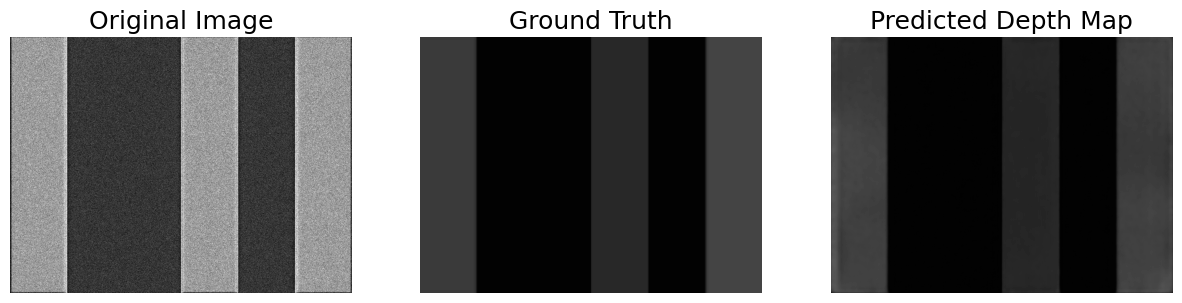

Predicted depth min = 0.0
Predicted depth max = 91.454704


In [ ]:
import torch
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from model import Resnet_UNet

def preprocess(image):
    from torchvision import transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1785, 0.1785, 0.1785], std=[0.1089, 0.1089, 0.1089])
    ])
    return transform(image)

def inference(image_path, model, max_depth=111.0):
    # 1) Load and preprocess the image (consistent with training)
    input_image = Image.open(image_path).convert('RGB')
    original_image = input_image  # Keep original size
    input_tensor = preprocess(input_image).unsqueeze(0).cuda()

    # 2) Model inference
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)  # Network output should be in [0,1]
        output = torch.clamp(output, 0.0, 1.0)  # Ensure range

    # 3) Post-processing: Move to CPU, remove batch dimension, convert to numpy, and restore actual depth (mm)
    output_np = output.squeeze().cpu().numpy()
    output_np = output_np * max_depth  # Convert to mm
    return original_image, output_np

def load_ground_truth(image_path):
    # Generate ground truth file path by replacing the file extension
    ground_truth_path = image_path.replace('.jpg', '_depth.png')
    
    # Load ground truth image (convert to grayscale)
    if os.path.exists(ground_truth_path):
        ground_truth_image = Image.open(ground_truth_path).convert('L')
        return ground_truth_image
    else:
        raise FileNotFoundError(f"Ground truth image not found at {ground_truth_path}")

# Load model
model.load_state_dict(torch.load('./model_weights.pth'))  # Load saved model parameters

# Input image path
image_path = './sem_images/data/triangles_0032_latest.jpg'

# Perform inference and display results
original_image, output = inference(image_path, model)

# Load ground truth image
ground_truth_image = load_ground_truth(image_path)

# Resize output to 1000x750 using cv2.resize (for consistent display)
output_resized = cv2.resize(output, (1000, 750), interpolation=cv2.INTER_LINEAR)

# Display original image, ground truth, and predicted depth map
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display original image
axs[0].imshow(original_image.resize((1000, 750)))  # Resize using PIL
axs[0].set_title('Original Image', fontsize=18)
axs[0].axis('off')

# Display ground truth image
axs[1].imshow(ground_truth_image.resize((1000, 750)), cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Ground Truth', fontsize=18)
axs[1].axis('off')

# Display predicted depth map (units: mm)
axs[2].imshow(output_resized, cmap='gray', vmin=0, vmax=255)
axs[2].set_title('Predicted Depth Map', fontsize=18)
axs[2].axis('off')

plt.show()

print("Predicted depth min =", output_resized.min())
print("Predicted depth max =", output_resized.max())


In [12]:
import os
print(os.getcwd())


/mnt/c/code/resnet_depthnet
